In [17]:
import csv
import re

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [19]:
from Bio.Seq import reverse_complement
from maxentpy import maxent_fast
from pysam import FastaFile
from tqdm import tqdm
from scipy.stats import ttest_ind

In [20]:
hsap_fe2gene = dict()
ptro_fe2gene = dict()

In [21]:
for name in ["homo_sapiens", "pan_troglodytes"]:
    with open(f"data/ref/{name}/annot/out/meta_exon.csv", 'r') as f:
        reader = csv.reader(f)
        next(reader)

        for row in reader:
            gene, gene_func, chrom, meta_beg, meta_end, strand, meta_type, make_up = row

            if meta_type != "FE" or gene_func != "protein_coding":
                continue

            strand = int(strand == "+")
            meta_exon = f"{chrom}:{meta_beg}-{meta_end}:{strand}"

            if name == "homo_sapiens":
                hsap_fe2gene[meta_exon] = gene
            else:
                ptro_fe2gene[meta_exon] = gene

In [22]:
hsap_genome = FastaFile(
    "../data/ref/homo_sapiens/fa/Homo_sapiens.GRCh38.dna_sm.toplevel.fa.gz")
ptro_genome = FastaFile(
    "../data/ref/pan_troglodytes/fa/Pan_troglodytes.Pan_tro_3.0.dna_sm.toplevel.fa.gz")

In [23]:
matrix5 = maxent_fast.load_matrix(5)

In [24]:
hsap_ptro = list()
long_data = list()

In [25]:
with open("../data/homology/exons/exons.csv", 'r') as f:
    reader = csv.DictReader(f)

    for row in reader:
        hsap = row['hsap_exon']
        ptro = row['pan_troglodytes']

        if ptro == "-":
            continue

        hsap_type, hsap = hsap.split("=")
        ptro_type, ptro = ptro.split("=")

        if hsap_type == "FE" \
                and ptro_type == "FE":
            hsap_ptro.append((hsap, ptro))

In [26]:
for homolog_pair in tqdm(hsap_ptro):
    hsap_fe, ptro_fe = homolog_pair

    if hsap_fe not in hsap_fe2gene \
            or ptro_fe not in ptro_fe2gene:
        continue

    hsap_gene = hsap_fe2gene[hsap_fe]
    ptro_gene = ptro_fe2gene[ptro_fe]

    stat = {
        'hsap': dict(),
        'ptro': dict()
    }

    for name, exon in zip(("hsap", "ptro"), homolog_pair):
        chrom, *pos = re.split('[:-]', exon)
        beg, end, strand = map(int, pos)

        if name == "hsap":
            genome = hsap_genome
        else:
            genome = ptro_genome

        seq = genome.fetch(chrom, beg-50, end+50)
        seq_len = len(seq)

        if strand == 0:
            seq = reverse_complement(seq)

        scores = list()
        for i in range(3, seq_len - 6):
            cand_seq = seq[i - 3: i + 6].upper()

            if "N" not in cand_seq:
                score = maxent_fast.score5(cand_seq, matrix5)
                if score > 0:
                    scores.append(score)

        if scores:
            stat[name]['num'] = len(scores)
            stat[name]['max'] = max(scores)
            stat[name]['sum'] = sum(scores)

        if not stat['hsap'] or not stat['ptro']:
            continue

        d_num = stat['hsap']['num'] - stat['ptro']['num']
        d_max = stat['hsap']['max'] - stat['ptro']['max']
        d_sum = stat['hsap']['sum'] - stat['ptro']['sum']

        if d_num == 0:
            d_num_bin = 0
        else:
            d_num_bin = -1 if d_num < 0 else +1

        if d_sum == 0:
            d_sum_bin = 0
        else:
            d_sum_bin = -1 if d_sum < 0 else +1

        if d_max == 0:
            d_max_bin = 0
        else:
            d_max_bin = -1 if d_max < 0 else +1

        long_data.append({
            'hsap_ptro': f"{hsap_gene}_{ptro_gene}",
            'hsap_gene': hsap_gene,
            'ptro_gene': ptro_gene,
            'hsap_fe': hsap_fe,
            'ptro_fe': ptro_fe,
            'hsap_num': stat['hsap']['num'],
            'ptro_num': stat['ptro']['num'],
            'hsap_max': stat['hsap']['max'],
            'ptro_max': stat['ptro']['max'],
            'hsap_sum': stat['hsap']['sum'],
            'ptro_sum': stat['ptro']['sum'],
            'd_num': d_num,
            'd_max': d_max,
            'd_sum': d_sum,
            'd_num_bin': d_num_bin,
            'd_max_bin': d_max_bin,
            'd_sum_bin': d_sum_bin,
        })

100%|██████████| 12374/12374 [00:12<00:00, 953.59it/s] 


In [27]:
maxent_frame = pd.DataFrame(long_data)
maxent_frame.to_csv("data/homology/exons/hsap_ptro_maxent.csv")

In [28]:
tpm_frame = pd.read_csv("../data/danko16/out/tpm/merged_log1p_tpm.csv")

In [29]:
frame = maxent_frame.merge(tpm_frame, on='hsap_ptro')
frame

,hsap_ptro,hsap_gene,ptro_gene,hsap_fe,ptro_fe,hsap_num,ptro_num,hsap_max,ptro_max,hsap_sum,ptro_sum,d_num,d_max,d_sum,d_num_bin,d_max_bin,d_sum_bin,hsap_log1p_mean,ptro_log1p_mean,log1p_hsap_minus_ptro
0,ENSG00000137265_ENSPTRG00000017656,ENSG00000137265,ENSPTRG00000017656,6:391739-391809:1,6:225315-225379:1,3,3,10.284364,10.284364,12.032529,12.032529,0,0.0,0.000000,0,0,0,5.894037,6.385915,-0.491878
1,ENSG00000137266_ENSPTRG00000017678,ENSG00000137266,ENSPTRG00000017678,6:3455906-3457050:0,6:3439249-3439917:0,17,9,10.512265,10.512265,26.415290,21.266486,8,0.0,5.148804,1,0,1,5.421628,4.772798,0.648830
2,ENSG00000168994_ENSPTRG00000017679,ENSG00000168994,ENSPTRG00000017679,6:3751276-3751713:0,6:3735863-3736323:0,10,10,8.166931,8.166931,18.442043,19.029851,0,0.0,-0.587808,0,0,-1,1.179247,4.651891,-3.472644
3,ENSG00000112739_ENSPTRG00000017683,ENSG00000112739,ENSPTRG00000017683,6:4021267-4021466:1,6:4003968-4004102:1,6,5,9.353542,9.353542,24.560944,19.054771,1,0.0,5.506173,1,0,1,6.272542,6.007342,0.265200
4,ENSG00000145975_ENSPTRG00000051400,ENSG00000145975,ENSPTRG00000051400,6:4087010-4087344:0,6:4069304-4069321:0,7,3,10.766342,10.766342,35.189275,13.198502,4,0.0,21.990773,1,0,1,5.365476,5.647933,-0.282457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10136,ENSG00000174450_ENSPTRG00000051938,ENSG00000174450,ENSPTRG00000051938,15:23447098-23447243:0,15:4512761-4512844:0,4,4,8.605702,8.605702,19.292119,19.292119,0,0.0,0.000000,0,0,0,0.000000,0.273052,-0.273052
10137,ENSG00000251192_ENSPTRG00000021829,ENSG00000251192,ENSPTRG00000021829,X:46545371-46545457:0,X:46729073-46729163:0,5,5,7.132257,7.132257,16.562138,16.562138,0,0.0,0.000000,0,0,0,4.401553,4.541760,-0.140207
10138,ENSG00000204363_ENSPTRG00000028276,ENSG00000204363,ENSPTRG00000028276,X:52797274-52797427:0,X:52463380-52463580:1,8,10,10.064666,10.064666,18.361079,21.282665,-2,0.0,-2.921586,-1,0,-1,0.000000,0.000000,0.000000
10139,ENSG00000171405_ENSPTRG00000028277,ENSG00000171405,ENSPTRG00000028277,X:52811287-52811412:1,X:52449442-52449838:0,5,15,6.956973,6.956973,16.685887,34.505476,-10,0.0,-17.819589,-1,0,-1,0.000000,0.000000,0.000000


Ttest_indResult(statistic=-3.989213445323233, pvalue=6.694392400974669e-05)
Ttest_indResult(statistic=0.19282284277794937, pvalue=0.8471051902216933)


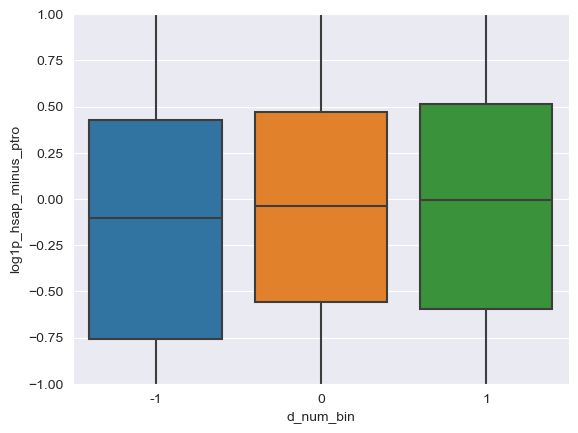

In [30]:
sns.boxplot(frame, x='d_num_bin', y='log1p_hsap_minus_ptro', showfliers=False)

print(ttest_ind(frame[frame['d_num_bin'] == -1]['log1p_hsap_minus_ptro'].values, frame[frame['d_num_bin'] == 0]['log1p_hsap_minus_ptro'].values))
print(ttest_ind(frame[frame['d_num_bin'] == 0]['log1p_hsap_minus_ptro'].values,  frame[frame['d_num_bin'] == 1]['log1p_hsap_minus_ptro'].values))

_ = plt.ylim(-1, 1)
plt.savefig("figs/main5a_num.pdf")

Ttest_indResult(statistic=-3.247850177364457, pvalue=0.0011684150020901897)
Ttest_indResult(statistic=0.6695934509045373, pvalue=0.503148354134509)


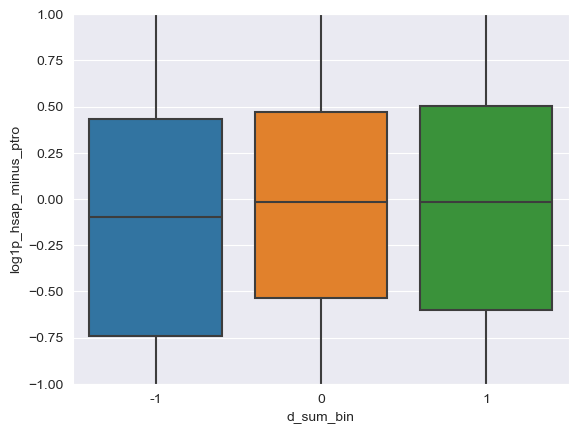

In [31]:
sns.boxplot(frame, x='d_sum_bin', y='log1p_hsap_minus_ptro', showfliers=False)

print(ttest_ind(frame[frame['d_sum_bin'] == -1]['log1p_hsap_minus_ptro'].values, frame[frame['d_sum_bin'] == 0]['log1p_hsap_minus_ptro'].values))
print(ttest_ind(frame[frame['d_sum_bin'] == 0]['log1p_hsap_minus_ptro'].values,  frame[frame['d_sum_bin'] == 1]['log1p_hsap_minus_ptro'].values))

_ = plt.ylim(-1, 1)
plt.savefig("figs/main5a_sum.pdf")

Ttest_indResult(statistic=-2.1291818250090486, pvalue=0.033264909746418506)
Ttest_indResult(statistic=1.1302248575907397, pvalue=0.25841139795591594)


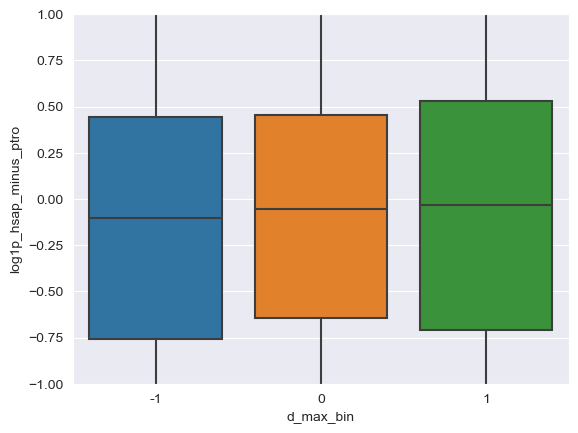

In [32]:
sns.boxplot(frame, x='d_max_bin', y='log1p_hsap_minus_ptro', showfliers=False)
_ = plt.ylim(-1, 1)

print(ttest_ind(frame[frame['d_max_bin'] == -1]['log1p_hsap_minus_ptro'].values, frame[frame['d_max_bin'] == 0]['log1p_hsap_minus_ptro'].values))
print(ttest_ind(frame[frame['d_max_bin'] == 0]['log1p_hsap_minus_ptro'].values,  frame[frame['d_max_bin'] == 1]['log1p_hsap_minus_ptro'].values))


plt.savefig("figs/main5a_max.pdf")